In [1]:
### summary: TOP SCORES: 
#52.5% with gaussian naive bayes
#52.5% with k-nn with ~200 neighbors
#52.5% with logistic regression and C~1e-2
#52% with a 2 depth decision tree
#always going for 1 -> 51%

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model
matplotlib.style.use('ggplot')
%matplotlib inline


In [2]:
numerai_data = pd.read_csv("./numerai_training_data.csv")
print numerai_data.head(5)

#separating train and test
frac_for_training = 0.80
training_data = numerai_data.sample(frac=frac_for_training)
validation_data = numerai_data.drop(training_data.index)
check = pd.merge(training_data, validation_data, how='inner')

training_data.drop('validation', axis=1, inplace=True)
validation_data.drop('validation', axis=1, inplace=True)

print('\n\n\nSize of datasets: total - %s, train - %s, test - %s, intersect: %s' %(
        numerai_data.shape[0], training_data.shape[0], validation_data.shape[0], check.shape[0]))

          f1         f2         f3         f4         f5         f6  \
0  134182390   97300587  135824563   90767607   87687197   65148427   
1   76630357  132348601   78121737  102794263  120848626  128752983   
2  111610401  132186734   83887688  120772423  133722193  100560251   
3   72896251  113365043   72912608  126007508  127949612   74975809   
4  113253706   96665624   89391907   77862818   91855586  100094204   

          f7         f8         f9        f10        f11        f12  \
0  109834029  131613166  135533479   92106582   98111205   87052852   
1   71827456   95945691   98115812  135285479  137364637  130062214   
2   69916843  100459177   80742177  134884316  129775817  131335813   
3   87833921   68438705   76021871  116126096  118784024  112328751   
4  116150057  114434231   98567673   86510339   81789481   87618174   

         f13        f14     c1  validation  target  
0   66216076  121781929  c1_23           0       1  
1  114819524   76635306   c1_3          

In [3]:
#preprocessing the categorical feature c1

from sklearn import preprocessing

try:
    training_data["c1_int"] = training_data["c1"].apply(lambda x: int(x[3:]))
except Exception:
    le = preprocessing.LabelEncoder()
    le.fit_transform(list(set(training_data["c1"])))
    training_data["c1_int"] = le.transform(np.asarray(training_data["c1"]))

print "Categorical feature transformed:"
print training_data[["c1", "c1_int"]].head(5)

binaries = pd.get_dummies(training_data['c1'], prefix='bin_', prefix_sep='', dummy_na=False, columns=['c1'], sparse=False)
training_data = pd.concat([training_data, binaries], axis=1)

#features:
quant_features = ['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11','f12','f13','f14']
binary_features = [c for c in training_data.columns if c.startswith('bin_')]
print ("\n\n\nQuant features are: %s" %','.join(quant_features))
print ("\n\n\nBinary features are: %s" %','.join(binary_features))

Categorical feature transformed:
          c1  c1_int
27372  c1_16      16
27075  c1_20      20
10274  c1_11      11
49591  c1_14      14
11377   c1_9       9



Quant features are: f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14



Binary features are: bin_c1_1,bin_c1_10,bin_c1_11,bin_c1_12,bin_c1_13,bin_c1_14,bin_c1_15,bin_c1_16,bin_c1_17,bin_c1_18,bin_c1_19,bin_c1_20,bin_c1_21,bin_c1_22,bin_c1_23,bin_c1_24,bin_c1_3,bin_c1_4,bin_c1_5,bin_c1_6,bin_c1_7,bin_c1_8,bin_c1_9


In [4]:
training_data[['c1']+binary_features].head(5)

,c1,bin_c1_1,bin_c1_10,bin_c1_11,bin_c1_12,bin_c1_13,bin_c1_14,bin_c1_15,bin_c1_16,bin_c1_17,...,bin_c1_22,bin_c1_23,bin_c1_24,bin_c1_3,bin_c1_4,bin_c1_5,bin_c1_6,bin_c1_7,bin_c1_8,bin_c1_9
27372,c1_16,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
27075,c1_20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10274,c1_11,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49591,c1_14,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11377,c1_9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


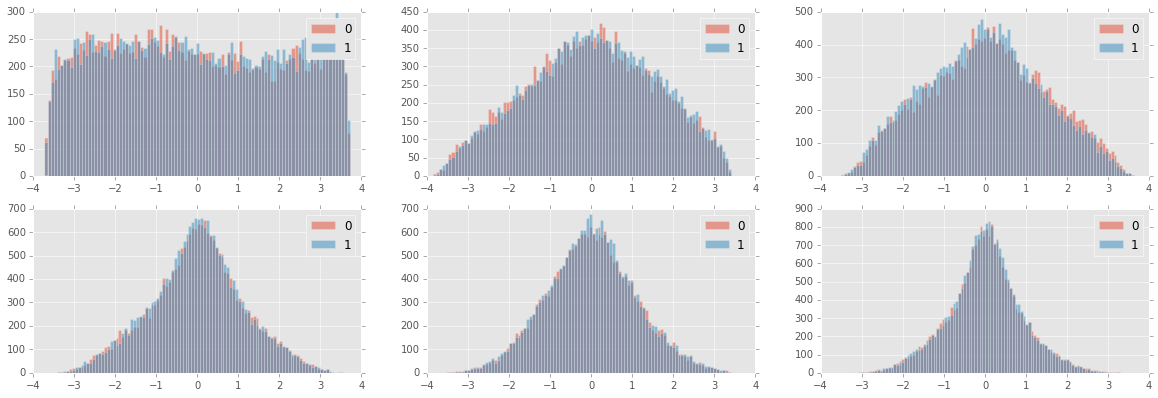

In [5]:
#PCA

from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
import math

variance_cutoff = 0.90

#scaled_features:
scaled_features = map(lambda f: 'scaled_'+f, quant_features)

#centering and scaling
for f in scaled_features:
    training_data[f] = 0
training_data[scaled_features] = training_data.loc[:,quant_features].apply(lambda x: (x-np.mean(x))/np.std(x), axis=1)

#PCA
pca_ = PCA()
pca_.fit(training_data.loc[:,scaled_features])
principal_components_features = map(lambda t: t[0]+str(t[1]), zip(["PC_"]*len(scaled_features), range(1,len(scaled_features)+1)))
for f in principal_components_features:
    training_data[f] = 0
training_data.loc[:,principal_components_features] = pca_.transform(training_data[scaled_features])

l_principal_components = np.argmax(np.cumsum(np.array(pca_.explained_variance_ratio_))>variance_cutoff)
principal_components_features = principal_components_features[0:l_principal_components]

plt.figure(figsize=(20,10))
for i in range(0,l_principal_components):
    ax = plt.subplot(math.ceil(math.sqrt(l_principal_components)), math.ceil(math.sqrt(l_principal_components)), i+1)
    bins = np.linspace(np.min(training_data.loc[:,principal_components_features[i]]), np.max(training_data.loc[:,principal_components_features[i]]), 100)
    ax.hist(training_data.ix[training_data.loc[:,'target']==0,principal_components_features[i]].tolist(), bins, alpha=0.5, label='0')
    ax.hist(training_data.ix[training_data.loc[:,'target']==1,principal_components_features[i]].tolist(), bins, alpha=0.5, label='1')
    ax.legend(loc='upper right')

plt.show()

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:431: DeprecationWarning: The parameter 'store_covariance' is deprecated as of version 0.17 and will be removed in 0.19. The parameter is no longer necessary because the value is set via the estimator initialisation or set_params method.
  "set_params method.", DeprecationWarning)


in sample score: 0.5240063593, out of sample score: 0.521053832292


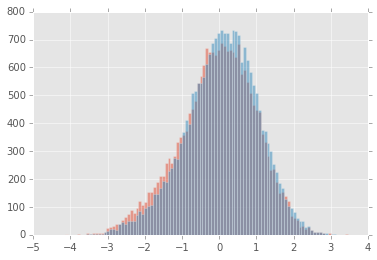

In [6]:
#LDA Projection on the vector of the 2 centroids + cv of LDA

from sklearn.lda import LDA
from sklearn.cross_validation import cross_val_score

LDA_features=quant_features

clf = sklearn.lda.LDA()
clf.fit(training_data[LDA_features], training_data['target'],store_covariance=True)
IS_score = clf.score(training_data[LDA_features], training_data['target'])
CV_score = np.mean(cross_val_score(clf, training_data[LDA_features], training_data['target'], cv=10))

print "in sample score: %s, out of sample score: %s" %(IS_score,CV_score)

training_data['lda_dir1'] = clf.transform(training_data[LDA_features])

lda_components = ['lda_dir1']

ax = plt.subplot(1,1,1)
bins = np.linspace(np.min(training_data.loc[:,'lda_dir1']), np.max(training_data.loc[:,'lda_dir1']), 100)
ax.hist(training_data.ix[training_data.loc[:,'target']==0,'lda_dir1'].tolist(), bins, alpha=0.5, label='0')
ax.hist(training_data.ix[training_data.loc[:,'target']==1,'lda_dir1'].tolist(), bins, alpha=0.5, label='1')
plt.show()



decision features:

['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'bin_c1_1', 'bin_c1_10', 'bin_c1_11', 'bin_c1_12', 'bin_c1_13', 'bin_c1_14', 'bin_c1_15', 'bin_c1_16', 'bin_c1_17', 'bin_c1_18', 'bin_c1_19', 'bin_c1_20', 'bin_c1_21', 'bin_c1_22', 'bin_c1_23', 'bin_c1_24', 'bin_c1_3', 'bin_c1_4', 'bin_c1_5', 'bin_c1_6', 'bin_c1_7', 'bin_c1_8', 'bin_c1_9']
       training_score  validation_score
depth                                  
1            0.519214          0.514558
2            0.523620          0.517307
3            0.528117          0.517466
4            0.528594          0.517352
5            0.532160          0.519146
6            0.538201          0.516512
7            0.545742          0.518283
8            0.554599          0.517693
9            0.562844          0.518238
10           0.577515          0.516716
11           0.592846          0.514967
12           0.612764          0.512174
13           0.631320          0.513718

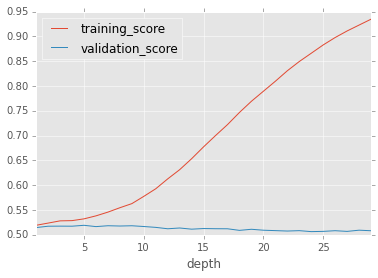

In [7]:
#decision tree

#classification score with a single regression tree

from sklearn import tree
from sklearn.cross_validation import cross_val_score

decision_features = quant_features+binary_features#principal_components_features#+binary_features

print 'decision features:\n' 
print decision_features

max_depths = range(1,30)
def cv_score(depth, printTree=False):
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    clf.fit(training_data[decision_features], training_data["target"])
    s = clf.score(training_data[decision_features], training_data["target"])
    m = np.mean(cross_val_score(clf, training_data[decision_features], training_data["target"], cv=5))
    dat = np.array([depth, s, m])
    if printTree:
        with open('./ClassificationTrees/singleClassifTreeWithDepth'+str(depth)+'.dot', 'w') as my_file:
            my_file = tree.export_graphviz(clf, out_file = my_file)
    return pd.DataFrame([dat],columns=['depth','training_score', 'validation_score'])

single_classif_tree_scores = pd.concat(map(lambda d: cv_score(d, True), max_depths))
single_classif_tree_scores.index = single_classif_tree_scores['depth']
single_classif_tree_scores.drop('depth',axis=1, inplace=True)

single_classif_tree_scores.plot(legend=True, grid=True)
print single_classif_tree_scores

#decision tree classifier:
best_depth = 3
decision_tree_classifier = tree.DecisionTreeClassifier(max_depth=best_depth)



In [8]:
# Naive Bayes Gaussian

from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score

nb_gaussian_features = quant_features+binary_features#principal_components_features

nb_gaussian_classifier = GaussianNB()
nb_gaussian_classifier.fit(training_data[nb_gaussian_features], training_data["target"])
s = nb_gaussian_classifier.score(training_data[nb_gaussian_features], training_data["target"])
m = np.mean(cross_val_score(nb_gaussian_classifier, training_data[nb_gaussian_features], training_data["target"], cv=10))
print "in sample score: %s, out of sample score: %s" %(s,m)


# naive bayes gaussian classifier
# nb_gaussian_classifier
nb_gaussian_classifier = GaussianNB()

in sample score: 0.523234158528, out of sample score: 0.521894199395


            C        IS        OS
0    0.010000  0.526050  0.522621
0    0.017783  0.526278  0.522894
0    0.031623  0.526005  0.522735
0    0.056234  0.526596  0.522621
0    0.100000  0.526686  0.522190
0    0.177828  0.526641  0.522076
0    0.316228  0.526686  0.522053
0    0.562341  0.526709  0.521940
0    1.000000  0.526732  0.521940
0    1.778279  0.526800  0.521872
0    3.162278  0.526777  0.521803
0    5.623413  0.526800  0.521803
0   10.000000  0.526823  0.521849
0   17.782794  0.526823  0.521872
0   31.622777  0.526800  0.521849
0   56.234133  0.526800  0.521849
0  100.000000  0.526823  0.521849
0  177.827941  0.526800  0.521849
0  316.227766  0.526800  0.521872
0  562.341325  0.526823  0.521872


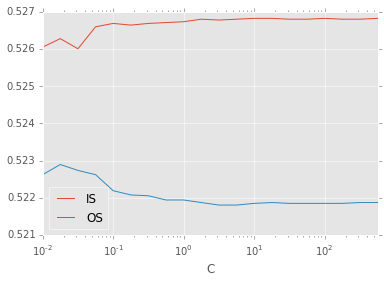

In [9]:
#Logistic regression

from sklearn.cross_validation import cross_val_score
import math

params = np.exp(np.arange(-2.0, 3.0,.25)*math.log(10))
log_reg_features = principal_components_features+binary_features

def apply_param(p):
    lreg_model = sklearn.linear_model.LogisticRegression(C=p)
    lreg_model.fit(training_data[log_reg_features], training_data["target"])
    IS = lreg_model.score(training_data[log_reg_features], training_data["target"])
    OS = np.mean(cross_val_score(lreg_model, training_data[log_reg_features], training_data["target"], cv=10))
    return pd.DataFrame([np.array([p, IS, OS])], columns=['C', 'IS', 'OS']) 

scores = pd.concat(map(apply_param, params))
scores.plot(x='C',logx=True)
print scores

#log reg classifier
best_p = 1.0
lreg_classifier = sklearn.linear_model.LogisticRegression(C=best_p)


['lda_dir1']
             training_score  validation_score
n_neighbors                                  
11                 0.630388          0.508222
18                 0.596412          0.506110
32                 0.572882          0.509312
57                 0.557960          0.511038
101                0.546673          0.514286
178                0.540995          0.512582
317                0.531524          0.516443
563                0.528821          0.522530
1001               0.527731          0.518760
1779               0.524551          0.522394
3163               0.525596          0.524302
5624               0.525346          0.523052


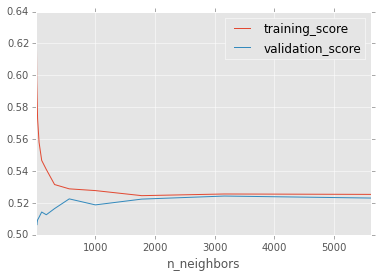

In [10]:
#k-nn
from sklearn.neighbors import KNeighborsClassifier
import math

n_neighbors = map(lambda x:int(math.ceil(x)), np.exp(np.arange(1.0, 4.0,.25)*math.log(10)).tolist())
k_nn_features = lda_components
print k_nn_features

def cv_score(par):
    clf = KNeighborsClassifier(n_neighbors=par)
    clf.fit(training_data[k_nn_features], training_data["target"])
    s = clf.score(training_data[k_nn_features], training_data["target"])
    m = np.mean(cross_val_score(clf, training_data[k_nn_features], training_data["target"], cv=5))
    dat = np.array([par, s, m])
    return pd.DataFrame([dat],columns=['n_neighbors','training_score', 'validation_score'])

k_nn_scores = pd.concat(map(cv_score, n_neighbors))
k_nn_scores.index = k_nn_scores['n_neighbors']
k_nn_scores.drop('n_neighbors',axis=1, inplace=True)

print k_nn_scores
k_nn_scores.plot(legend=True, grid=True)


#k-nn classifier
best_nn = 3000
k_nn_classifier = KNeighborsClassifier(best_nn)



In [11]:
#TO DO: 
#try QDA in case covariance changes | y
#try votes of k-nn on each principal component + the LDA axis - first try to figure out if that actually makes sense - does it have a chance to work?


In [15]:
#TO DO:
#ensemble model of:
# - naive bayes gaussian on original data -> global classif, 
# - 3000-nn on LDA space -> local classif
# maybe - decision tree on original features or PCA features with depth 3 -> global classif (low depth)
# maybe - logistic regression with all features + c1 binarized or just the LDA components with c1 binarized -> global classif (low depth)

from sklearn.ensemble import VotingClassifier
from sklearn import cross_validation

ensemble_classifiers = [nb_gaussian_classifier, k_nn_classifier, lreg_classifier]

# Training classifiers
ensemble_classifier = VotingClassifier(estimators=[('nbg', nb_gaussian_classifier), ('knn', k_nn_classifier), ('lreg', lreg_classifier)],
                        voting='soft')

ensemble_classifier = ensemble_classifier.fit(training_data[quant_features+lda_components+principal_components_features+binary_features],training_data['target'])

for clf, label in zip([nb_gaussian_classifier, k_nn_classifier, lreg_classifier, ensemble_classifier], [
        'Naive Bayes Gaussian', 'K-nn + LDA', 'logistic regression', 'Ensemble']):
    scores = cross_validation.cross_val_score(clf, training_data[
            quant_features+lda_components+principal_components_features+binary_features],training_data['target'], cv=5, scoring='accuracy')
    print("Accuracy: %0.4f (+/- %0.4f) [%s]" % (scores.mean(), scores.std(), label))

#predict probas, scale to [0;1] and combine them: majority vote (average of the majority), or average of probas

#Out of sample:
# 1. project new observations to the LDA space
# 2. estimate the probabilities from the three classifiers
# 3. combine them
# 4. make predictions



Accuracy: 0.5242 (+/- 0.0013) [Naive Bayes Gaussian]
Accuracy: 0.5218 (+/- 0.0048) [K-nn + LDA]
Accuracy: 0.5208 (+/- 0.0047) [logistic regression]
Accuracy: 0.5231 (+/- 0.0026) [Ensemble]


In [12]:
# correlation beteen classifiers:
import numpy as np

classifiers = [nb_gaussian_classifier, k_nn_classifier, lreg_classifier]

for clf in classifiers:
    clf.fit(training_data[quant_features+lda_components+principal_components_features+binary_features], training_data["target"])

probas = np.array(training_data.shape[0],len(classifiers))
for i in range(0,len(classifiers)):
    probas[:,i] = clf.predict_proba(training_data[quant_features+lda_components+principal_components_features+binary_features])

print np.corrcoef(probas)



TypeError: data type not understood

In [14]:
np.array([2,3])

array([2, 3])